# Posterior sampling

We will perform posterior sampling for the following model:

$$
p(x) \propto \exp\left(
-\frac{x_1^2}{10}
-\frac{x_2^2}{10}
-2(x_2 - x_1^2)^2
\right),
$$

$$
p(y \mid x) = \mathcal{N}(y; Hx, 0.1),
$$

where

$$
H = [0, 1].
$$

We assume that we have observed

$$
y = 2,
$$

and we would like to implement a few sampling methods.

We must consider how to set appropriate hyperparameters such as:

- chain length  
- proposal noise  
- step size  

In [5]:
import numpy as np
y = np.array([2.0])
sig_lik = 0.1
H = np.array([0, 1])

We begin by coding log-densities directly

In [6]:
def prior(x): # code banana density for visualisation purposes
 return np.exp(-x[0] **2 / 10 - x[1] ** 2 / 10 - 2 * (x[1] - x[0] ** 2) ** 2)
def log_prior(x):
 # To avoid numerical issues, input function directly rather than logging the prior function
 return -x[0] **2 / 10 - x[1] ** 2 / 10 - 2 * (x[1] - x[0] ** 2) ** 2
def log_likelihood(y, x, sig):
 H = np.array([0, 1])
 Hx = np.dot(H, x)
 return float(- 0.5 * np.log(2 * np.pi) - 0.5 * np.log(sig) - y ** 2 / (2 * sig) - Hx ** 2 / (2 * sig) + y * Hx / sig)

print(log_prior([0, 1]))
print(log_likelihood(y, np.array([0, 1]), sig_lik))

-2.1
-4.767645986707649


Next, we implement the random walk Metropolis algorithm (RWMH) for this target, setting an appropriate chain length, proposal variance, and burnin value. We then plot a scatter-plot with our samples. We use log-densities only.

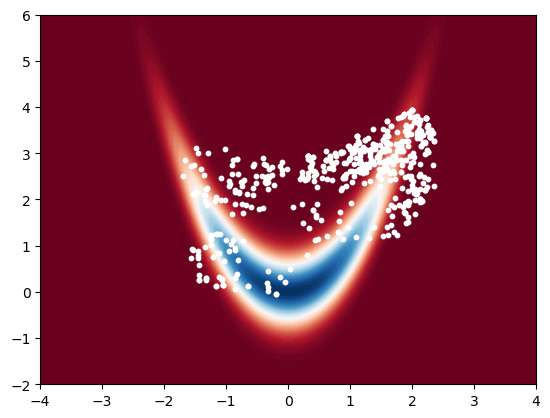

In [14]:
import matplotlib.pyplot as plt

chain_length = 15000
prop_var = 0.05
burnin = 14500
x = np.zeros((chain_length, 2))
x[0] = [0,2]
for n in range(1, chain_length):
 # Sampling from proposal distribution
    x_prime = np.random.multivariate_normal(x[n - 1], prop_var * np.eye(2))
 # No proposal distribution in acceptance ratio, as it is symmetric so cancels out
    log_acc_rat = min(0, log_prior(x_prime) + log_likelihood(y, x_prime, sig_lik) - \
    log_prior(x[n]) - log_likelihood(y, x[n], sig_lik))
    if np.log(np.random.rand()) < log_acc_rat:
        x[n] = x_prime
    else:
        x[n] = x[n - 1]

x = x[burnin:chain_length]

x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x[:, 0], x[:, 1], s=10 , c='white')
plt.show()

Now we implement the Metropolis-adjusted Langevin algorithm. For this, we will need to code the gradient of the density and use it in the proposal, as well as setting an appropriate chain length, step-size, and burnin value. We plot a scatter-plot with our samples. Again, we use log-densities only. 

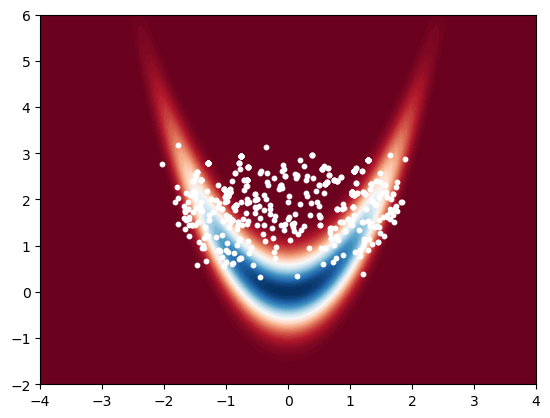

In [23]:
def grad_log_prior(x): # fill in the arguments
    return np.array([- x[0] / 5 + 8 * x[0] * (x[1] - x[0] ** 2), - x[1] / 5 - 4 * (x[1] - x[0] ** 2)])

def grad_log_likelihood(y, x, sig):
    return np.array([0, float(- x[1] / sig + y / sig)])
def log_MALA_kernel(x, gam):
    return x + gam * (grad_log_likelihood(y, x, sig_lik) + grad_log_prior(x)) + \
    np.sqrt(2 * gam) * np.random.multivariate_normal(np.zeros(2), np.eye(2))

gam = 0.1
chain_length = 10000
prop_var = 0.01
burnin = 9500
x = np.zeros((chain_length, 2))
x[0] = [0,2]
for n in range(1, chain_length):
    x_prime = log_MALA_kernel(x[n - 1], gam)
 # Acceptance ratio includes the proposal, as it is no longer symmetric so doesn't cancel on numerator and denomina
    log_acc_rat = min(0, log_prior(x_prime) + log_likelihood(y, x_prime, sig_lik) + \
                  1 / 4 * np.dot((2 * x[n - 1] - 2 * x_prime - gam * \
                  (grad_log_prior(x[n-1]) + grad_log_likelihood(y, x[n-1], sig_lik) \
                  - grad_log_prior(x_prime) - grad_log_likelihood(y, x_prime, sig_lik))), \
                  -(grad_log_prior(x[n-1]) + grad_log_likelihood(y, x[n-1], sig_lik) + \
                  grad_log_prior(x_prime) + grad_log_likelihood(y, x_prime, sig_lik)))
                  - log_prior(x[n]) - log_likelihood(y, x[n], sig_lik))
    if np.log(np.random.rand()) < log_acc_rat:
        x[n] = x_prime
    else:
        x[n] = x[n - 1]

x = x[burnin:chain_length]
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x[:, 0], x[:, 1], s=10 , c='white')
plt.show()

Next, we implement the unadjusted Langevin algorithm in the same manner as MALA - very similar, just without the acceptance ratio "if" statement

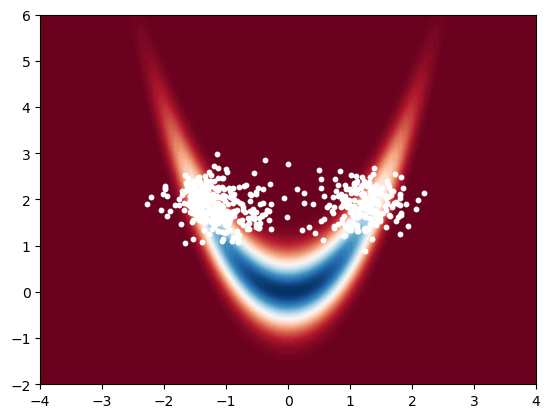

In [24]:
gam = 0.04
chain_length = 50000
prop_var = 0.9
burnin = 49500
x = np.zeros((chain_length, 2))
x[0] = [0,2]
for n in range(1, chain_length):
    x_prime = log_MALA_kernel(x[n - 1], gam)
    x[n] = x_prime

x = x[burnin:chain_length]
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x[:, 0], x[:, 1], s=10 , c='white')
plt.show()